In [ ]:
import os
import random
from datetime import datetime
import ast

import gc
import yaml
from tqdm import tqdm

import numpy as np

import torch
from torch.utils.tensorboard import SummaryWriter

from preprocessing.default_preprocessing import serve_data
from models.transformer_encoder import TransEncoder
from models.baseline import BaseLineModel
from ddpm import GaussianDiffusion1D
from evaluation.pca_tsne import visualize_pca_tsne
from evaluation.jsd import compute_jsd

random.seed(42)
np.random.seed(42)

In [ ]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()

# Parameters

In [ ]:
config_path = "./config.yml"
with open(config_path, 'r') as f:
    config = yaml.full_load(f)

date = datetime.today().strftime('%Y-%m-%d-%H-%M')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

seq_len = config["seq_len"]
epochs = config["epochs"]
timesteps = config["timesteps"]
batch_size = config["batch_size"]
latent_dim = config["latent_dim"]
num_layers = config["num_layers"]
n_heads = config["n_heads"]
beta_schedule = config["beta_schedule"]
objective = config["objective"]
subset_len = config["subset_len"]
model_name = config["model_name"]
cond_model = config["cond_model"]
lr = float(config["lr"])
betas = tuple_of_floats = ast.literal_eval(config["betas"])
save_rate = config["save_rate"]

log_file_name = f"{model_name}_{cond_model}_{str(date)}"
tb_writer = f"./logging/tensorboard/{log_file_name}"


# Data

In [3]:
train_loader, test_loader, features, cond_features = serve_data(seq_len, batch_size, subset_len)

num of channels in transformer: 1 
num of cond feature: 3
Train shape (batch, features, seq_len): (19988, 1, 15)
Cond shape (batch, features, seq_len): (19988, 3, 15)
batched data shape: torch.Size([32, 1, 15])


# Model

In [ ]:
if model_name == "TransEncoder":
    model = model = TransEncoder(features = features, latent_dim = latent_dim,num_heads = n_heads, num_layers = num_layers, cond_features=cond_features, cond_model=cond_model, device=device)
if model_name == "BaseLine":
    model = BaseLineModel(input_size=seq_len, hidden_size=latent_dim, cond_features=cond_features, cond_model=cond_model, device=device)
    
ddpm = GaussianDiffusion1D(model, seq_length = seq_len, timesteps = timesteps, objective = objective, loss_type = 'l2', beta_schedule = beta_schedule)
ddpm = ddpm.to(device)

optim = torch.optim.Adam(ddpm.parameters(), lr = lr, betas = betas)
writer = SummaryWriter(tb_writer)

c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


## Train

In [5]:
run_path = f"./logging/weights/{log_file_name}"
os.makedirs(run_path)

step=0
for running_epoch in tqdm(range(epochs)):
    for i, (data, cond_data) in enumerate(train_loader):
        data = data.to(device)
        
        cond_data = cond_data.float()
        cond_data = cond_data.to(device)
        
        batch_size = data.shape[0]
        
        optim.zero_grad()

        loss = ddpm(data, cond_data)
        loss.backward()
        
        optim.step()
        
        writer.add_scalar("Training Loss", loss, global_step=step)
        step += 1
        
    if i%len(train_loader)== 0 and running_epoch%10==0:
        print(f'Epoch: {running_epoch+1}, Loss: {loss.item()}')
    
if running_epoch % save_rate == 0:
    torch.save({

        'epoch': running_epoch+1,
        'diffusion_state_dict': ddpm.state_dict(),
        'diffusion_optim_state_dict': optim.state_dict()

        }, os.path.join(f'{run_path}', f'{running_epoch}-weights.pth'))

100%|██████████| 10/10 [02:00<00:00, 12.10s/it]


## Sampling

In [6]:
with torch.no_grad():
    samples = ddpm.sample(32)
    samples = samples.cpu().numpy()
    samples = samples.transpose(0, 2, 1)

print(f"Samples shape: {samples.shape}")

sampling loop time step: 100%|██████████| 1000/1000 [00:03<00:00, 297.93it/s]

Samples shape: (32, 15, 1)


# Evaluation
## Without Conditioning

In [7]:
real_data_train, real_cond_data_train = next(iter(train_loader))
real_data_test, real_cond_data_test = next(iter(test_loader))

### T-SNE and PCA

c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


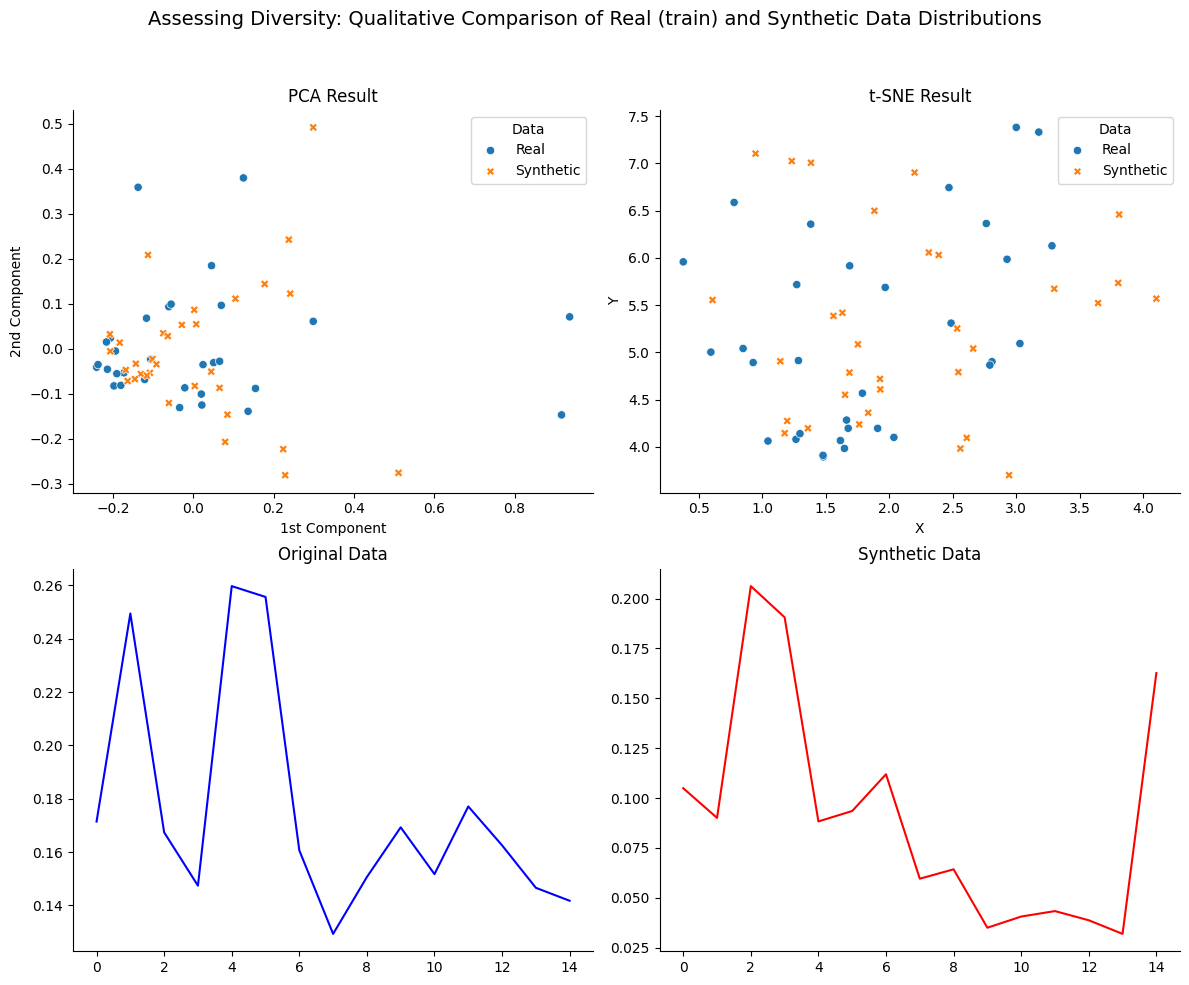

In [8]:
visualize_pca_tsne(ori_data=real_data_train.cpu().numpy().transpose(0,2,1), fake_data=samples, seq_len=seq_len, train_test="train", filename=log_file_name, cond=False)

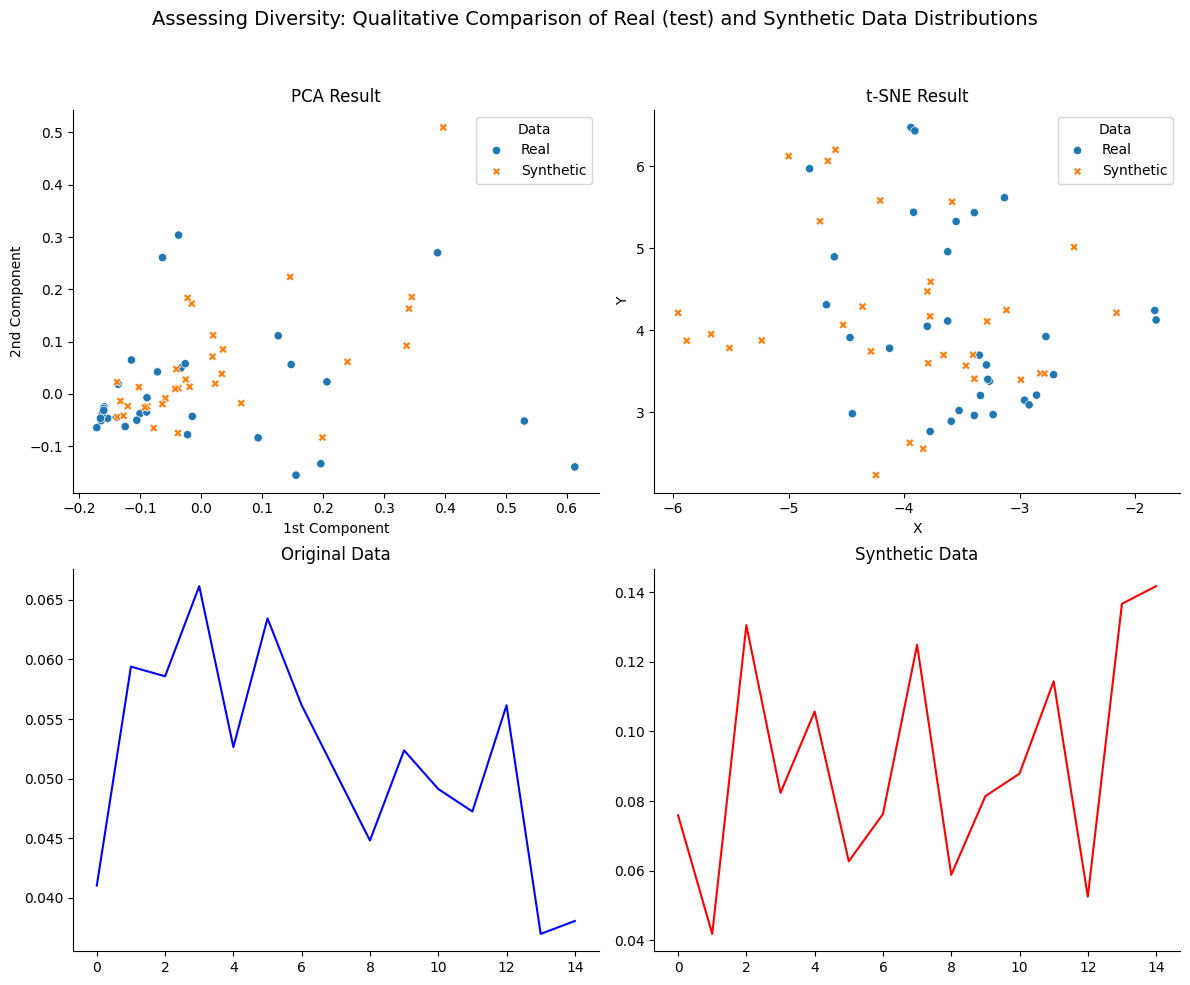

In [9]:
visualize_pca_tsne(ori_data=real_data_test.cpu().numpy().transpose(0,2,1), fake_data=samples, seq_len=seq_len, train_test="test", filename=log_file_name, cond=False)

### Jensen-Shannon Divergence

In [10]:
jsd_no_con_train = compute_jsd(real_data_train, samples)
jsd_no_con_test = compute_jsd(real_data_test, samples)

jsd_no_con_train, jsd_no_con_test

(0.35746898417612727, 0.38120301867469986)

## With Conditioning

In [11]:
with torch.no_grad():
    cond_samples = ddpm.sample(32, real_cond_data_train.to(device))
    cond_samples = cond_samples.cpu().numpy()
    cond_samples = cond_samples.transpose(0, 2, 1)

print(f"Samples shape: {cond_samples.shape}")

sampling loop time step: 100%|██████████| 1000/1000 [00:06<00:00, 160.74it/s]

Samples shape: (32, 15, 1)


### T-SNE and PCA

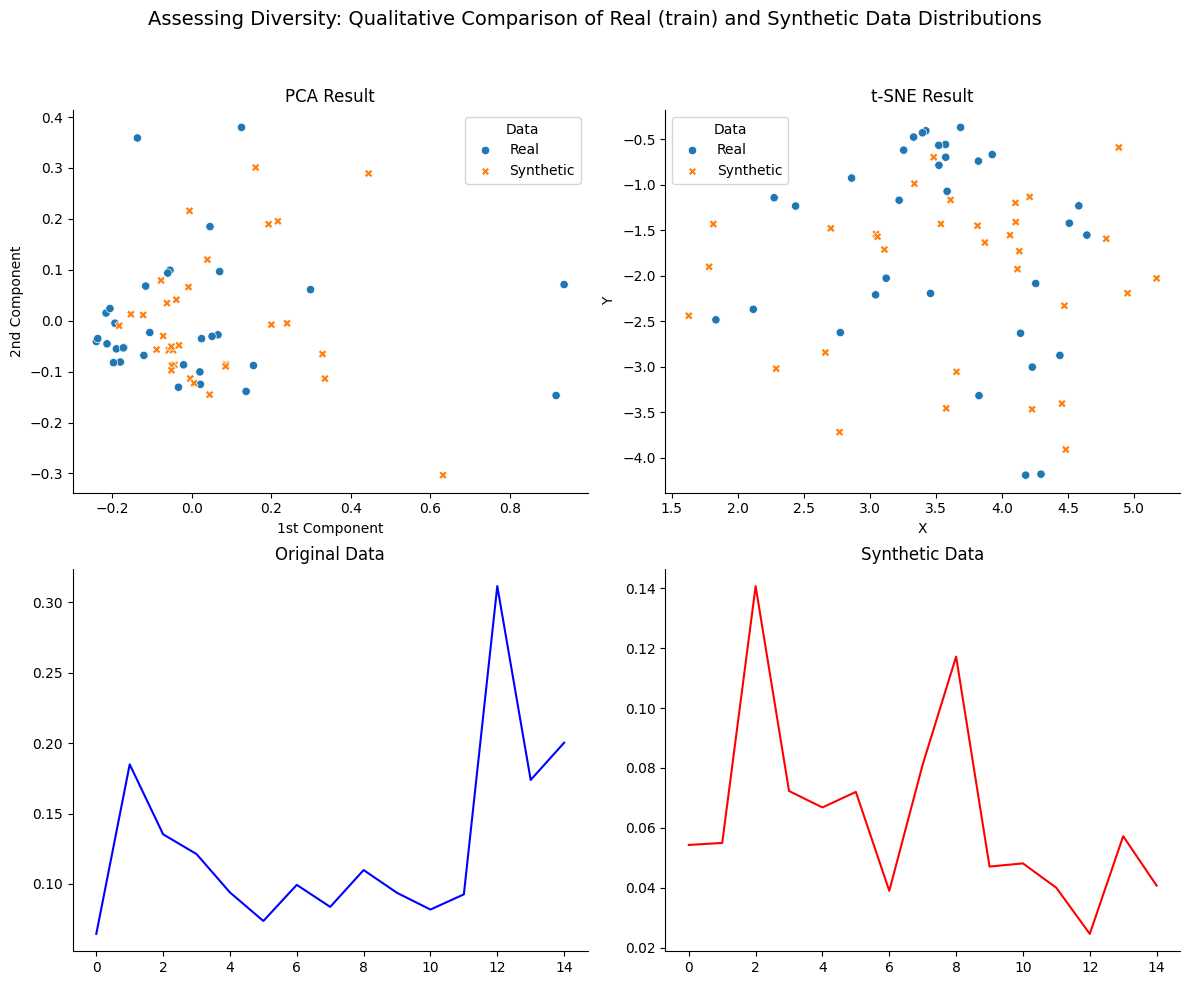

In [12]:
visualize_pca_tsne(ori_data=real_data_train.cpu().numpy().transpose(0,2,1), fake_data=cond_samples, seq_len=seq_len, train_test="train", filename=log_file_name, cond=True)

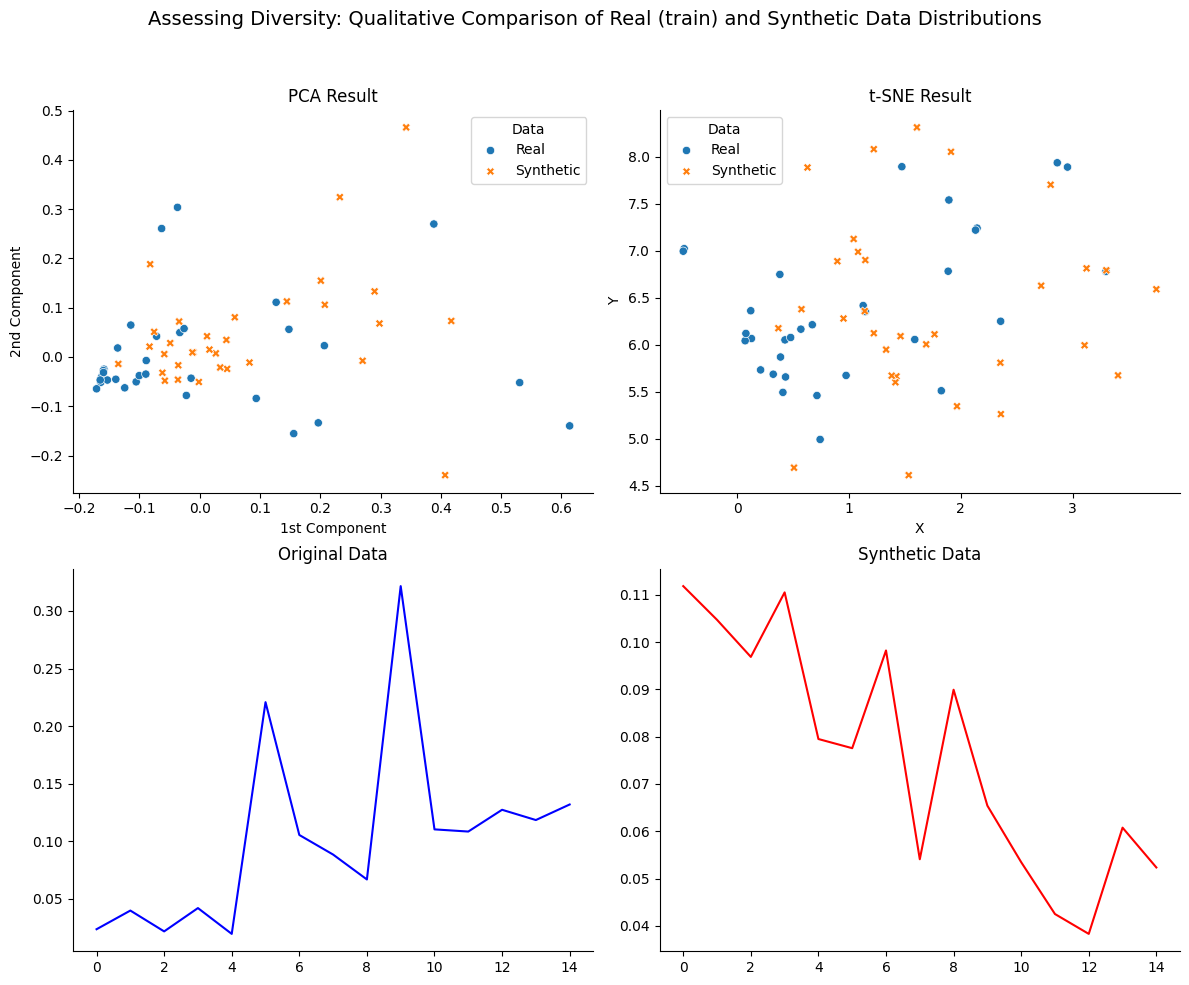

In [13]:
visualize_pca_tsne(ori_data=real_data_test.cpu().numpy().transpose(0,2,1), fake_data=cond_samples, seq_len=seq_len, train_test="train", filename=log_file_name, cond=True)

### Jensen-Shannon Divergence

In [14]:
jsd_con_train = compute_jsd(real_data_train, cond_samples)
jsd_con_test = compute_jsd(real_data_test, cond_samples)

jsd_con_train, jsd_con_test

(0.4110131814377463, 0.41175489875586363)

# Logging

In [15]:
log_dir = "./logging/logs"
log_file_path = os.path.join(log_dir, log_file_name + ".txt")

jsd = {
    "jsd_no_con_train": jsd_no_con_train, 
    "jsd_no_con_test": jsd_no_con_test,
    "jsd_con_train": jsd_con_train, 
    "jsd_con_test": jsd_con_test
}

with open(log_file_path, 'w') as log_file:
    log_file.write("Config:\n")
    for key, value in config.items():
        log_file.write(f"{key}: {value}\n")
    
    log_file.write("\nJSD Values:\n")
    for key, value in jsd.items():
        log_file.write(f"{key}: {value}\n")

print(f"Log file created at: {log_file_path}")

Log file created at: ./logging/logs\TransEncoder_te_2025-02-19-17-26.txt
